In [34]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# base_model = ResNet50(weights='imagenet', include_top=False)


In [35]:
# x = base_model.output

# x = GlobalAveragePooling2D()(x)

# x = Dropout(.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(.5)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(.5)(x)
# x = Dense(64, activation='relu')(x)

# predictions = Dense(2, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    
    # Conv2D(256,(3,3),activation='relu',input_shape=(128,128,3)),
    # MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(128,activation='relu'),
    Dense(2,activation='softmax')
])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'accuracy'])
# model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\LabeledImages\train'
validation_data_dir = r'..\Data\LabeledImages\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [37]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical')


Found 12197 images belonging to 2 classes.
Found 5320 images belonging to 2 classes.


In [38]:
import numpy as np

# class_counts = np.bincount(train_generator.classes) ** 0.3

# class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = 1 / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
class_probabilities = class_probabilities / np.sum(class_probabilities)

class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


noStopSigns: 0.030253340985488233
stopSigns: 0.9697466590145117


In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)            

In [40]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=50,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=20,
#     class_weight = class_weights,
#     )

import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy

# Initialize lists to store the metrics after each epoch
train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(8):  # Number of epochs
    # Training phase
    history = model.fit(
        train_generator,
        # steps_per_epoch=100,
        epochs=1,  # We're controlling the epochs manually with our loop
        class_weight=class_weights,
    )

    # Save the training metrics
    train_accs.append(history.history['categorical_accuracy'][0])
    train_losses.append(history.history['loss'][0])

    # Validation phase
    val_preds = model.predict(validation_generator)
    
    # Gather your validation labels here
    val_labels = np.array([])
    for i in range(len(validation_generator)):
        _, labels_batch = next(validation_generator)
        val_labels = np.vstack([val_labels, labels_batch]) if val_labels.size else labels_batch

    # Calculate weighted metrics manually
    sample_weights = np.vectorize(class_weights.get)(np.argmax(val_labels, axis=1))
    weighted_accuracy = np.sum(sample_weights * (np.argmax(val_preds, axis=1) == np.argmax(val_labels, axis=1))) / np.sum(sample_weights)
    print(f"Weighted accuracy on validation set: {weighted_accuracy}")

    # Save the validation metrics
    val_accs.append(weighted_accuracy)
    
    # Calculate your validation loss here
    val_loss = categorical_crossentropy(val_labels, val_preds)

    if tf.executing_eagerly():
        # If running eager execution, convert Tensor to NumPy array directly
        val_loss = val_loss.numpy().mean()
    else:
        # If running graph execution, use a Session to evaluate the Tensor
        with tf.Session() as sess:
            val_loss = sess.run(val_loss).mean()

    val_losses.append(val_loss)


191/191 [==============================] - 41s 216ms/step - loss: 0.0417 - categorical_accuracy: 0.5759 - acc: 0.5759
Weighted accuracy on validation set: 0.5277772263602383
191/191 [==============================] - 62s 325ms/step - loss: 0.0407 - categorical_accuracy: 0.4542 - acc: 0.4542s - l
Weighted accuracy on validation set: 0.4886336749677959
191/191 [==============================] - 38s 202ms/step - loss: 0.0407 - categorical_accuracy: 0.2367 - acc: 0.2367
Weighted accuracy on validation set: 0.5113663250322044
191/191 [==============================] - 39s 207ms/step - loss: 0.0407 - categorical_accuracy: 0.9247 - acc: 0.9247
Weighted accuracy on validation set: 0.5113663250322042
191/191 [==============================] - 67s 350ms/step - loss: 0.0407 - categorical_accuracy: 0.1181 - acc: 0.1181
Weighted accuracy on validation set: 0.5113663250322044
191/191 [==============================] - 55s 287ms/step - loss: 0.0407 - categorical_accuracy: 0.5404 - acc: 0.5404 24s - l

KeyboardInterrupt: 

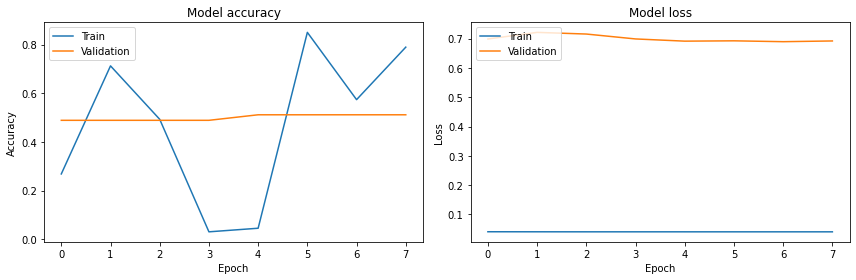

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs)  
plt.plot(val_accs) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.save('TrainedStopModel.h5')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\LabeledImages\val'
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical')

class_names = generator.class_indices.keys()
#print(class_names)

Found 5320 images belonging to 2 classes.


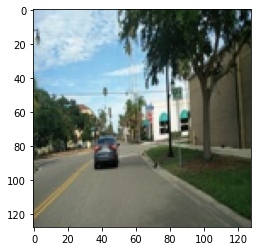

Country: ['noStopSigns'], Probability: 0.5005266070365906
Country: ['stopSigns'], Probability: 0.49947336316108704


In [ ]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\LabeledImages\val\stopSigns\DR5f7ZIYgKWNweNNd4CD9g.jpg'
img = image.load_img(img_path, target_size=(128, 128))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [ ]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



1.15.8
GPU found
